In [1]:
% matplotlib inline
import bidict
import os
import csv
import scipy.sparse
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def get_chembls(filename):
    result = []
    first_line = True
    with open(filename, 'r') as f:
        for line in f:
            if first_line:
                assert 'CHEMBL' in line
                result.append(line.strip())
                first_line = False
            elif '$$$$' in line:
                first_line=True
            else:
                pass
    return result

In [3]:
def get_mapping(all_compounds_file):
    mapping = bidict.bidict()
    all_chembls = get_chembls(all_compounds_file)        
    mapping.update(dict(zip(xrange(len(all_chembls)), all_chembls)))

    return mapping

In [4]:
def get_all_files(path):
    return [os.path.join(path,filename) for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename))]

In [5]:
def load_similarity_matrices(all_compunds_file, folder_with_pairs):
    bin_similarity = []
    scale_similarity = []
    row_ind = []
    col_ind = []
    
    mapping_idx_chembl = get_mapping(all_compunds_file)
    n_compunds = len(mapping_idx_chembl)
    dict_idx_chemblchembl = \
    dict( [ [int(''.join(c for c in filename if c.isdigit() )), tuple(get_chembls(filename))] \
          for filename in get_all_files(folder_with_pairs) ] )
       
    ###################################
    # # # zapewnij unikalność par # # #
    ###################################
    non_unique={}
    for key in sorted(dict_idx_chemblchembl.keys()):
        chembl_i, chembl_j = dict_idx_chemblchembl[key]
        for another_key in sorted(dict_idx_chemblchembl.keys()):
            if key!=another_key \
            and chembl_i in dict_idx_chemblchembl[another_key]\
            and chembl_j in dict_idx_chemblchembl[another_key]:
                new_key = min(key, another_key)
                new_value = max(key, another_key)
                if new_key not in non_unique.keys():
                    non_unique[new_key] = [new_value]
                else:
                    if non_unique[new_key] is None:
                        print non_unique
                    non_unique[new_key].append(new_value)
    pairs_to_omit = set([item for sublist in non_unique.values() for item in sublist])
    
    ## TODO print ile par ominieto
    ######################
    # # # zapewniono # # #
    ######################
    
    
    n_omitted = 0
    with open('Similarity.csv', 'r') as csvfile:
        for pair_number, bin_sim, scale_sim in csv.reader(csvfile, delimiter=','):
            if int(pair_number) not in pairs_to_omit:
                chembl_i, chembl_j = dict_idx_chemblchembl[int(pair_number)]
                chembl_i_idx, chembl_j_idx = mapping_idx_chembl.inv[chembl_i], mapping_idx_chembl.inv[chembl_j]
                row_ind.extend([chembl_i_idx, chembl_j_idx])
                col_ind.extend([chembl_j_idx, chembl_i_idx])
                bin_similarity.extend([int(bin_sim), int(bin_sim)])
                scale_similarity.extend([int(scale_sim), int(scale_sim)])
            else:
                n_omitted += 1
    
    assert (len(dict_idx_chemblchembl)-n_omitted)*2 == len(bin_similarity)
    assert len(bin_similarity)==len(scale_similarity)
    assert len(scale_similarity)==len(row_ind)
    assert len(row_ind)==len(col_ind)    
     
    # we want bin similarities to be -1, 1 not 0, 1
    bin_similarity = [(-1)**(1-x) for x in bin_similarity]
    assert 0 not in scale_similarity
    assert 0 not in bin_similarity
    
    scale_similarity = scipy.sparse.csr_matrix((scale_similarity, (row_ind, col_ind)), shape=(n_compunds, n_compunds))
    bin_similarity   = scipy.sparse.csr_matrix((bin_similarity,   (row_ind, col_ind)), shape=(n_compunds, n_compunds))
    
    assert scale_similarity.nnz == len(row_ind)
    assert bin_similarity.nnz == len(row_ind)
    
    # a compound is always similar to itself
    scale_similarity.setdiag(5*np.ones((scale_similarity.shape[0])))
    bin_similarity.setdiag(np.ones((bin_similarity.shape[0])))
    
    assert np.all(scale_similarity.todense() == np.transpose(scale_similarity.todense()))
    assert scale_similarity.shape == (n_compunds, n_compunds)
    assert np.all(bin_similarity.todense() == np.transpose(bin_similarity.todense()))
    assert bin_similarity.shape == (n_compunds, n_compunds)
    
    assert scale_similarity.nnz == bin_similarity.nnz
    assert np.all(scale_similarity.indices == bin_similarity.indices)
    assert np.all(scale_similarity.nonzero()[0] == bin_similarity.nonzero()[0])
    assert np.all(scale_similarity.nonzero()[1] == bin_similarity.nonzero()[1])
    
    return bin_similarity, scale_similarity, mapping_idx_chembl

In [6]:
bin_sim, scale_sim, mapping_idx_chembl = load_similarity_matrices('Random_compounds_100.sdf', 'pairs')

/home/nex/Libraries/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [7]:
print bin_sim.nnz
print scale_sim.nnz

a, b = bin_sim.nonzero()[0], bin_sim.nonzero()[1]
c, d = scale_sim.nonzero()[0], scale_sim.nonzero()[1]

print a.shape, c.shape
print b.shape, d.shape

print np.all(a==c)
print np.all(b==d)

958
958
(958,) (958,)
(958,) (958,)
True
True


In [8]:
print get_chembls('pairs/Random_pair11.sdf')
print get_chembls('pairs/Random_pair267.sdf')

['CHEMBL426317', 'CHEMBL2397911']
['CHEMBL426317', 'CHEMBL2397911']


In [ ]:
def find_best_folds(all_compunds_file, folder_with_pairs):
    possible_compounds = 'possible compounds'
    pairs_contained = 'pairs contained'
    best_clustering = None
    best_score = 336
    scores = []
    varianves = []
    n_ommited_pairs = []
    while(True): # many times
        bin_sim, scale_sim, mapping_idx_chembl = load_similarity_matrices(all_compunds_file, folder_with_pairs)
        bin_sim.setdiag(np.zeros((bin_sim.shape[0]))) # pairs (i,i) are not interesting for us
        pairs = zip(bin_sim.nonzero()[0], bin_sim.nonzero()[1])
        random.shuffle(pairs)
        clusters = [{possible_compounds:list(mapping_idx_chembl.keys()), pairs_contained:[]} for i in xrange(10)]
        ommited_pairs = 0
        try:
            while(True):
                i, j = pairs.pop() # popping random pair
                if i > j:
                    continue # saving time
                
                pair_in_set = False
                for cluster in clusters:
                    # if possible
                    if i in cluster[possible_compounds] and j in cluster[possible_compounds]:
                        pair_in_set = True
                        # add pair to cluster
                        cluster[pairs_contained].append((i,j))
                        
                        # usun zwiazki i, j z mozliwych w kazdym klastrze poza obecnym
                        for c in clusters:
                            if i in c[possible_compounds]:
                                c[possible_compounds].remove(i)
                            if j in c[possible_compounds]:
                                c[possible_compounds].remove(j)
                        cluster[possible_compounds].extend([i, j])
                        random.shuffle(clusters)
                        break  # pair was added to one cluster, our job is done in here
                        
                if not pair_in_set:
                    ommited_pairs+=1 
                    
                
        except IndexError:
            variance = np.var([len(cluster[pairs_contained]) for cluster in clusters])
            score = variance + ommited_pairs # chcemy niską wariancję i mało pominiętych par
            
            if score < best_score:
                print '\n'
                print "score", score, 'variance', variance, 'ommited_pairs', ommited_pairs
                best_score = score
                best_clustering = clusters
                scores.append(best_score)
                varianves.append(variance)
                n_ommited_pairs.append(ommited_pairs)
                plt.plot(range(len(scores)), scores, c='r')
                plt.plot(range(len(varianves)), varianves, c='g')
                plt.plot(range(len(n_ommited_pairs)), n_ommited_pairs, c='b')
                plt.title('best score over time')
                plt.show()
                print best_clustering
                print 'wielkości klastrów', [len(cluster[pairs_contained]) for cluster in clusters]
                print 'pominietych par', ommited_pairs
                print best_score
            if variance < 1 and ommited_pairs < 10:
                break
    return best_clustering



score 366.25 variance 52.25 ommited_pairs 314


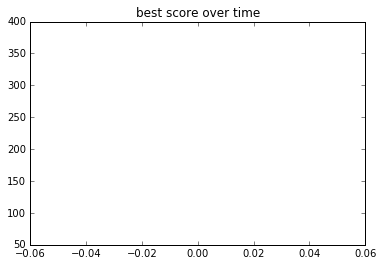

[{'possible compounds': [13], 'pairs contained': []}, {'possible compounds': [13, 56, 69, 25, 74, 54, 67, 91, 89, 50, 2, 7, 86], 'pairs contained': [(50, 86), (56, 86), (2, 54), (7, 56), (56, 91), (2, 69), (54, 74), (7, 89), (25, 74), (7, 54), (67, 91), (50, 89), (2, 50), (2, 7), (7, 86)]}, {'possible compounds': [13, 72, 12, 1, 46, 16, 5, 23, 97, 24, 62, 48, 66], 'pairs contained': [(1, 72), (12, 48), (1, 24), (24, 46), (48, 62), (16, 97), (5, 48), (62, 66), (23, 97), (24, 62), (48, 66)]}, {'possible compounds': [13, 8, 27, 44, 29, 33], 'pairs contained': [(8, 44), (27, 44), (29, 33)]}, {'possible compounds': [13, 14, 60, 73, 68, 30, 65, 84, 93, 0, 34, 43, 81, 3, 53], 'pairs contained': [(34, 65), (3, 65), (34, 60), (3, 30), (84, 93), (14, 81), (65, 73), (30, 60), (53, 84), (68, 73), (0, 68), (30, 43), (3, 34), (30, 65), (43, 84), (53, 93), (0, 34), (43, 81), (3, 53)]}, {'possible compounds': [13, 28, 49, 42, 21, 32, 41, 76, 98, 45, 83, 87, 51, 35, 59, 22, 36, 15, 82], 'pairs containe

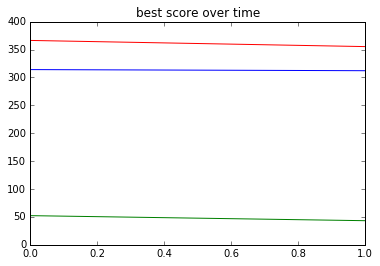

[{'possible compounds': [13, 89, 85, 80, 50, 18, 43, 30, 65, 3, 5], 'pairs contained': [(30, 80), (30, 43), (5, 43), (3, 30), (65, 80), (50, 89), (30, 85), (18, 85), (50, 80), (5, 18), (5, 50), (18, 43), (30, 65), (5, 65), (3, 65), (3, 5)]}, {'possible compounds': [13, 58, 78], 'pairs contained': [(58, 78)]}, {'possible compounds': [13, 28, 36, 23, 83, 96, 37, 61, 7, 9], 'pairs contained': [(28, 96), (37, 96), (7, 61), (9, 96), (28, 36), (23, 96), (83, 96), (37, 61), (7, 9)]}, {'possible compounds': [13, 16, 87, 32, 76, 44, 70, 27, 71, 29, 33], 'pairs contained': [(32, 44), (16, 87), (27, 44), (32, 33), (29, 76), (44, 70), (27, 71), (29, 33)]}, {'possible compounds': [13, 49, 35, 86, 46, 81, 94, 17, 20], 'pairs contained': [(35, 94), (20, 49), (81, 94), (20, 86), (35, 86), (46, 81), (17, 94), (17, 20)]}, {'possible compounds': [13, 74, 54, 84, 53, 93, 97], 'pairs contained': [(84, 97), (53, 54), (54, 74), (84, 93), (54, 93), (53, 97), (53, 84), (53, 93), (93, 97)]}, {'possible compound

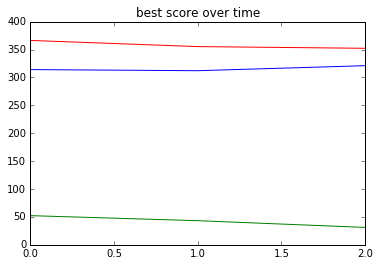

[{'possible compounds': [13, 4, 42, 66, 84, 93, 28, 27, 58, 43, 12, 35, 47, 6, 49, 71], 'pairs contained': [(27, 49), (43, 84), (6, 28), (27, 35), (35, 42), (4, 6), (42, 66), (84, 93), (28, 47), (27, 71), (6, 58), (43, 58), (12, 58), (49, 58), (12, 43), (12, 35), (47, 71), (6, 49), (49, 71)]}, {'possible compounds': [13, 9, 92, 80, 96, 16, 69, 21, 85, 19, 23, 97], 'pairs contained': [(85, 96), (9, 96), (80, 92), (16, 80), (19, 85), (16, 97), (23, 96), (16, 69), (21, 85), (19, 23), (23, 97)]}, {'possible compounds': [13, 89, 18, 5, 50], 'pairs contained': [(50, 89), (5, 18), (5, 50)]}, {'possible compounds': [13, 68, 55, 57, 53, 77, 78, 31, 75], 'pairs contained': [(53, 75), (57, 75), (55, 78), (68, 75), (31, 55), (55, 57), (53, 77), (31, 78), (31, 75)]}, {'possible compounds': [13, 76, 29, 51, 1, 33, 38, 60, 72, 61, 0, 37], 'pairs contained': [(29, 33), (29, 76), (1, 29), (1, 72), (38, 60), (37, 51), (1, 61), (0, 72), (33, 38), (60, 72), (37, 61), (0, 37)]}, {'possible compounds': [13,

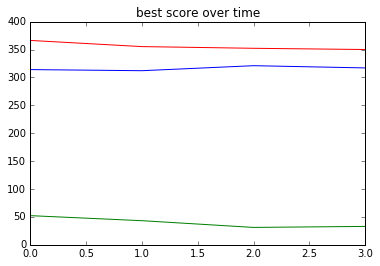

[{'possible compounds': [13, 77, 37, 26, 55, 15, 47, 45, 59, 18, 95, 17, 27, 96, 1, 61], 'pairs contained': [(37, 61), (61, 77), (37, 96), (26, 55), (27, 95), (1, 15), (15, 47), (17, 59), (45, 59), (18, 95), (1, 17), (27, 96), (1, 61)]}, {'possible compounds': [13, 6, 60, 29, 99, 5, 24, 74, 94, 82, 91, 4, 85], 'pairs contained': [(4, 6), (24, 99), (60, 91), (29, 91), (4, 82), (24, 85), (74, 99), (5, 82), (4, 94), (24, 91), (74, 94), (82, 91), (4, 85)]}, {'possible compounds': [13, 51, 98, 28, 41, 25, 52], 'pairs contained': [(41, 51), (25, 28), (28, 98), (28, 52), (41, 52), (25, 52)]}, {'possible compounds': [13, 2, 54, 33, 69, 57, 66, 62, 31, 75, 11, 48], 'pairs contained': [(2, 69), (48, 57), (2, 62), (2, 54), (31, 33), (11, 57), (48, 66), (33, 69), (57, 75), (62, 66), (48, 62), (31, 75), (11, 48)]}, {'possible compounds': [13, 14, 38, 86, 50, 89], 'pairs contained': [(14, 89), (14, 38), (50, 86), (50, 89)]}, {'possible compounds': [13, 8, 44, 70], 'pairs contained': [(8, 44), (44, 7

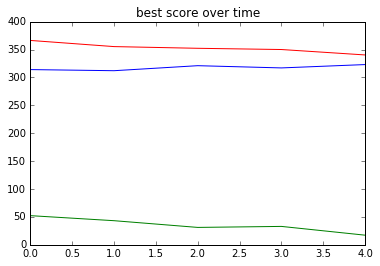

[{'possible compounds': [13, 68, 69, 73, 90, 24, 66, 62, 21, 32], 'pairs contained': [(68, 73), (68, 69), (21, 62), (24, 73), (32, 69), (73, 90), (24, 62), (62, 66), (32, 62), (21, 32)]}, {'possible compounds': [13, 58, 19, 45, 82, 6, 83, 7, 99, 77, 2, 61], 'pairs contained': [(6, 58), (6, 19), (7, 61), (2, 7), (19, 77), (19, 82), (2, 99), (82, 83), (45, 82), (6, 83), (7, 99), (61, 77), (2, 61)]}, {'possible compounds': [13, 3, 41, 76, 52, 30, 95], 'pairs contained': [(41, 52), (3, 30), (30, 52), (41, 76), (52, 95), (30, 95)]}, {'possible compounds': [13, 16, 5, 65, 63, 64, 40, 8, 39, 25, 74], 'pairs contained': [(63, 74), (39, 65), (25, 63), (16, 25), (5, 65), (63, 64), (39, 40), (8, 39), (25, 74)]}, {'possible compounds': [13, 15, 47, 60, 50, 92, 72, 78, 31, 29, 91, 1, 17, 80, 94], 'pairs contained': [(17, 94), (1, 15), (15, 47), (1, 72), (60, 72), (60, 91), (29, 80), (50, 80), (80, 92), (1, 29), (31, 78), (72, 78), (31, 91), (29, 91), (1, 17), (80, 94)]}, {'possible compounds': [13,

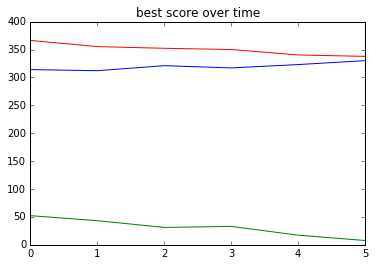

[{'possible compounds': [13, 47, 3, 75, 52, 83, 84, 24, 42, 66, 1, 72, 37, 96], 'pairs contained': [(47, 52), (3, 96), (42, 75), (37, 75), (24, 52), (83, 96), (83, 84), (1, 24), (42, 66), (1, 72), (37, 96)]}, {'possible compounds': [13, 38, 77, 99, 33, 56, 64, 68, 70, 2, 17, 32, 44], 'pairs contained': [(2, 70), (44, 70), (33, 38), (38, 77), (2, 99), (32, 33), (56, 64), (68, 70), (2, 17), (32, 44)]}, {'possible compounds': [13, 8, 45, 31, 55, 78], 'pairs contained': [(31, 78), (8, 45), (31, 55), (55, 78)]}, {'possible compounds': [13, 40, 6, 65, 73, 15, 9, 87, 49, 71], 'pairs contained': [(6, 87), (6, 40), (6, 15), (6, 49), (6, 73), (9, 73), (65, 73), (9, 15), (15, 71), (9, 71), (49, 87), (49, 71)]}, {'possible compounds': [13, 98, 80, 30, 85, 18, 95, 23, 19, 57], 'pairs contained': [(57, 98), (30, 95), (18, 57), (80, 98), (23, 30), (30, 85), (19, 85), (30, 80), (19, 30), (18, 85), (18, 95), (19, 23), (19, 57)]}, {'possible compounds': [13, 34, 74, 20, 39, 93, 97, 25, 51, 16, 69], 'pai

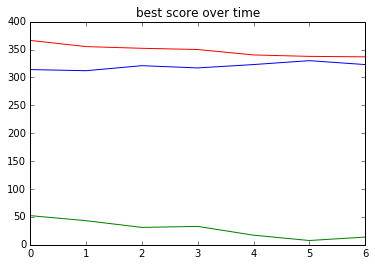

[{'possible compounds': [13, 32, 99, 33, 47, 29, 76, 24, 52], 'pairs contained': [(47, 99), (32, 33), (24, 99), (24, 76), (29, 33), (47, 52), (29, 76), (24, 52)]}, {'possible compounds': [13, 62, 65, 92, 86, 17, 26, 98, 20, 56, 11, 27, 49, 21, 64], 'pairs contained': [(56, 86), (21, 62), (65, 92), (64, 92), (20, 86), (11, 64), (17, 20), (11, 27), (11, 26), (11, 98), (20, 49), (56, 64), (11, 21), (27, 49), (21, 64)]}, {'possible compounds': [13, 74, 55, 23, 53, 84, 54, 93, 97], 'pairs contained': [(84, 97), (53, 54), (54, 74), (53, 93), (54, 55), (23, 97), (53, 84), (53, 97), (84, 93), (54, 93), (93, 97)]}, {'possible compounds': [13, 71, 75, 42, 66, 6, 41, 38, 35, 45, 57], 'pairs contained': [(38, 75), (6, 38), (57, 75), (42, 75), (71, 75), (35, 42), (42, 66), (6, 41), (38, 57), (35, 45), (45, 57)]}, {'possible compounds': [13, 0, 16, 25, 46, 37, 51], 'pairs contained': [(0, 37), (16, 25), (16, 51), (25, 46), (37, 51)]}, {'possible compounds': [13, 44, 39, 40, 91, 19, 22, 77], 'pairs c

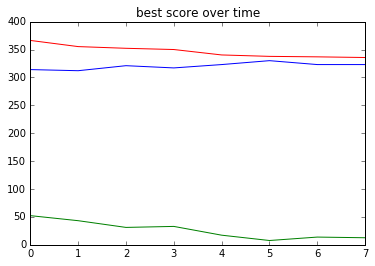

[{'possible compounds': [13, 21, 10, 25, 92, 86, 93, 28, 6, 56, 64, 76, 41, 52], 'pairs contained': [(25, 52), (21, 64), (10, 86), (25, 28), (64, 92), (28, 52), (56, 86), (56, 93), (6, 28), (6, 41), (56, 64), (41, 76), (41, 52)]}, {'possible compounds': [13, 33, 12, 35, 42, 66], 'pairs contained': [(12, 33), (12, 35), (35, 42), (42, 66)]}, {'possible compounds': [13, 0, 89, 37, 51, 83, 96, 8, 45, 50, 80], 'pairs contained': [(37, 80), (0, 37), (50, 89), (8, 89), (37, 96), (37, 51), (45, 51), (83, 96), (8, 45), (50, 80)]}, {'possible compounds': [13, 68, 75, 43, 14, 72, 1, 46, 81, 34, 69], 'pairs contained': [(68, 69), (68, 75), (43, 81), (14, 81), (14, 72), (1, 72), (1, 34), (46, 81), (34, 69)]}, {'possible compounds': [13, 58, 30, 7, 20, 49, 39, 32, 27, 44], 'pairs contained': [(20, 32), (49, 58), (20, 30), (27, 49), (7, 27), (20, 39), (20, 49), (39, 44), (32, 44), (27, 44)]}, {'possible compounds': [13, 60, 54, 18, 85, 61, 17, 70, 79, 2, 62], 'pairs contained': [(2, 70), (60, 79), (2

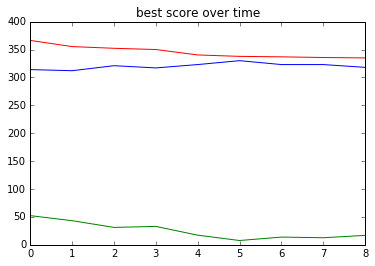

[{'possible compounds': [13, 93, 56, 91, 67, 22, 70, 43, 18, 95], 'pairs contained': [(67, 70), (67, 91), (56, 91), (56, 93), (18, 56), (91, 95), (22, 91), (43, 91), (22, 67), (22, 70), (18, 43), (18, 95)]}, {'possible compounds': [13, 52, 34, 15, 26, 55, 24, 76, 1, 29], 'pairs contained': [(24, 52), (29, 76), (34, 76), (1, 34), (29, 55), (1, 24), (1, 15), (26, 55), (24, 76), (1, 29)]}, {'possible compounds': [13, 60, 41, 51, 38, 6, 44, 27, 49], 'pairs contained': [(6, 49), (27, 44), (38, 60), (27, 60), (6, 41), (41, 51), (6, 38), (6, 44), (27, 49)]}, {'possible compounds': [13, 47, 14, 72, 46, 81, 9, 71, 73, 86], 'pairs contained': [(47, 71), (9, 86), (14, 81), (9, 73), (14, 72), (46, 81), (9, 71), (73, 86)]}, {'possible compounds': [13, 83, 84, 80, 12, 33], 'pairs contained': [(83, 84), (80, 84), (33, 80), (12, 80), (12, 33)]}, {'possible compounds': [13, 0, 28, 5, 65, 40, 66, 62, 48, 57], 'pairs contained': [(0, 57), (0, 28), (5, 48), (5, 65), (48, 66), (40, 48), (62, 66), (48, 62),

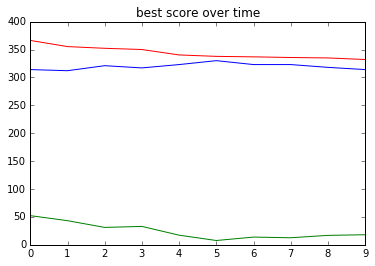

[{'possible compounds': [13, 83, 23, 54, 96, 67, 27, 71, 63, 74, 25, 28], 'pairs contained': [(28, 96), (63, 96), (83, 96), (23, 96), (63, 74), (54, 74), (27, 96), (25, 63), (63, 67), (27, 71), (28, 63), (25, 74), (25, 28)]}, {'possible compounds': [13, 49, 92, 82, 47, 6, 44, 19, 91, 40, 52, 30, 65], 'pairs contained': [(82, 92), (44, 52), (6, 49), (19, 82), (6, 19), (65, 92), (82, 91), (6, 30), (6, 40), (47, 52), (6, 44), (19, 30), (40, 91), (40, 52), (30, 52), (30, 65)]}, {'possible compounds': [13, 66, 97, 60, 62, 3, 38, 77, 39, 57, 15, 87, 98, 20, 32], 'pairs contained': [(32, 62), (62, 66), (38, 57), (15, 97), (38, 60), (20, 39), (62, 87), (3, 38), (38, 77), (39, 87), (57, 98), (15, 32), (87, 98), (20, 32)]}, {'possible compounds': [13, 18, 42, 0, 72, 78, 95], 'pairs contained': [(18, 95), (42, 95), (0, 72), (72, 78), (78, 95)]}, {'possible compounds': [13, 85, 88, 24, 50, 76, 10, 17, 37, 75, 70, 79, 84, 53, 93], 'pairs contained': [(84, 93), (79, 93), (24, 85), (75, 88), (24, 76)

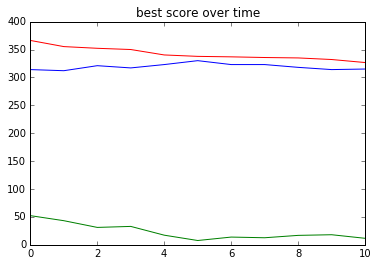

[{'possible compounds': [13, 98, 75, 68, 42, 66, 20, 54, 0, 28, 47, 71], 'pairs contained': [(42, 75), (28, 98), (28, 47), (68, 75), (20, 75), (71, 75), (0, 68), (42, 66), (20, 54), (0, 28), (47, 71)]}, {'possible compounds': [13, 65, 38, 26, 55, 78, 18, 57, 3, 30], 'pairs contained': [(3, 65), (30, 65), (3, 38), (38, 57), (55, 57), (26, 55), (55, 78), (18, 57), (3, 30)]}, {'possible compounds': [13, 39, 44, 43, 84, 19, 90, 23, 97], 'pairs contained': [(90, 97), (19, 43), (39, 44), (84, 97), (19, 23), (19, 84), (43, 44), (43, 84), (19, 90), (23, 97)]}, {'possible compounds': [13, 8, 34, 72, 73, 94, 10, 96, 9, 1, 4], 'pairs contained': [(73, 96), (8, 94), (1, 34), (10, 73), (9, 96), (1, 72), (4, 73), (9, 73), (4, 94), (73, 94), (9, 10), (4, 96), (4, 9), (1, 4)]}, {'possible compounds': [13, 24, 46, 81, 60, 22, 91, 67, 70], 'pairs contained': [(24, 91), (24, 46), (67, 91), (46, 81), (60, 91), (22, 67), (22, 70), (22, 91), (67, 70)]}, {'possible compounds': [13, 11, 12, 88, 21, 85, 33, 69

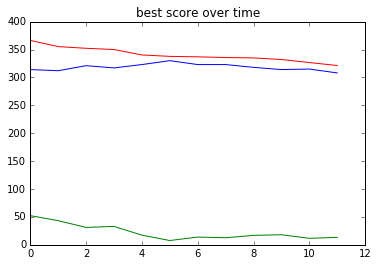

[{'possible compounds': [13, 43, 89, 10, 19, 90, 22, 77], 'pairs contained': [(19, 43), (19, 77), (10, 90), (10, 89), (19, 22), (10, 19), (19, 90), (22, 77)]}, {'possible compounds': [13, 60, 15, 95, 64, 92, 11, 71, 78, 27, 49, 58], 'pairs contained': [(15, 58), (27, 95), (78, 95), (27, 60), (15, 71), (11, 95), (11, 64), (64, 92), (49, 71), (11, 27), (27, 71), (58, 78), (27, 49), (49, 58)]}, {'possible compounds': [13, 61, 50, 88, 56, 46, 7, 9, 86, 12, 80], 'pairs contained': [(7, 61), (80, 88), (7, 56), (50, 80), (50, 86), (7, 9), (12, 88), (56, 86), (46, 56), (46, 80), (7, 86), (9, 86), (12, 80)]}, {'possible compounds': [13, 42, 83, 16, 3, 38, 84, 18, 93, 5, 82, 53, 97], 'pairs contained': [(84, 97), (3, 53), (83, 84), (3, 5), (16, 42), (82, 83), (16, 97), (84, 93), (3, 38), (53, 84), (53, 93), (5, 18), (93, 97), (5, 82), (53, 97)]}, {'possible compounds': [13, 57, 76, 69, 0, 34], 'pairs contained': [(0, 57), (34, 76), (34, 69), (0, 34)]}, {'possible compounds': [13, 31, 14, 33, 29,

In [ ]:
best_clustering = find_best_folds('Random_compounds_100.sdf', 'pairs')

In [ ]:
best_clustering